In [14]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib qt
%matplotlib inline
%load_ext watermark
%watermark

Last updated: 2022-02-15T15:37:49.245158+01:00

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.12.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 23 Model 8 Stepping 2, AuthenticAMD
CPU cores   : 12
Architecture: 64bit



# Plan

1. Description of trapped ions.
2. Simulation in 1D with velocity-Verlet.
3. Simulation in 1D with Runge-Kutta fourth-order
    1. (first method)
    2. (second method)
4. Other references.

# 1. Trapped ions physics

In 1D the motion equation of a trapped ion $i$, in an RF field, with friction and Coulomb interaction is as follows :

$m\ddot y_i = \frac{2q_eU_{RF}}{r_0^2}\cos\Omega t ~y_i + q_e^2k_C\sum_{j=1}^N \frac{y_i-y_j}{d_{ij}^3} - \gamma\dot y_i$

Numerically solve this equation is equivalent to obtain the set of variables $y_i$, $v_i=\frac{\mathrm{d}y_i}{\mathrm{d}t}$ and $a_i = \frac{\mathrm{d^2}y_i}{\mathrm{d}t^2}$ that fulfill this equation. Several methods can be used. In our Fortran code, when there are no friction velocity-Verlet method (VV) is used, but when friction is implemented another method must be used. Blümel *et al* use Runge-Kutta fourth order method (RK4). This document deals with both VV and RK4.

For RK4 it is convenient to write the second order differential equation as a system of two first order differential equations

$\dot y_i = v_i \\ \dot v_i = a_i = \frac{2q_eU_{RF}}{r_0^2}\cos\Omega t ~y_i + q_e^2k_C\sum_{j=1}^N \frac{y_i-y_j}{d_{ij}^3} - \gamma v_i$

It may seems that this decomposition is artificial, expecially because there is no analytical expression for the velocity $v_i$. Nevertheless this is no problem because the actual value for the velocity $v_i$ is know at the beginning of each step of RK4 algorithm.

# 2. Simulation of a trapped ion

In [15]:
# definition of physical variables
C_e = 1.602e-19
m_Ca = 40.078*1.66054e-27 # mass of trapped ion
r0 = 2.5e-3    # trap internal radius
Omega = 2*np.pi*2e6  # RF field angular frequency
Urf = 40       # RF voltage amplitude

### With velocity-Verlet
Velocity-Verlet method is used as reference

In [16]:
# velocity-verlet for the trapped ion
class velocity_verlet:
    def update_position(x,v,a1_vv): # return x
        return x + v*dt_vv + 0.5*a1_vv*dt_vv**2
    def update_acceleration(x,t): # return a2
        return 2*C_e*Urf/(m_Ca*r0**2)*np.cos(Omega*t)*x
    def update_velocity(v,a1_vv,a2_vv): # return v
        return v + 0.5*(a1_vv+a2_vv)*dt_vv

# variables simu
dt_vv = 2*np.pi/(100*Omega) # s
nper = 50

t_vv = np.arange(0,nper*100*dt_vv,dt_vv)
x_vv,v_vv,a1_vv = [[],[],[]]

# initialisation
x_vv.append(r0/4)
a1_vv.append(velocity_verlet.update_acceleration(x_vv[0],t_vv[0]))
a2_vv = []
b.append(0)

# VV algorithm

for time in t_vv[:-1]:
    x_vv.append( velocity_verlet.update_position(x_vv[-1],v_vv[-1],a1_vv[-1]) )
    a2_vv.append( velocity_verlet.update_acceleration(x_vv[-1],time) )
    v_vv.append( velocity_verlet.update_velocity(v_vv[-1],a1_vv[-1],a2_vv[-1]) )
    a1_vv.append(a2_vv[-1])

### 3. Runge-Kutta fourth-order method

##### Runge-Kutta of order 4 (RK4)

$y_i(t_n)$ is the value of the quantity $y_i$ at time $t_n$. The RK4 algorithm estimates the value of the same quantity $y_i$ at the next simulation step $t_{n+1}$ using two intermediate estimate values at midpoint and one estimate value at endpoint. The time step $h$ is defined so that $t_{n+1}-t_n=h$. RK4 proceeds in 4 steps where everytime it estimates the slope of the value in different conditions :
1. Estimates the derivative (slope) $k_1$ at initial point. This allows to compute a first approximation of $y_i(t_{n+1})$.
2. Estimates the derivative (slope) $k_2$ at midpoint using $k_1$.
3. Estimates the derivative (slope) $k_3$ at midpoint using $k_2$.
4. Estimates the derivative (slope) $k_4$ at midpoint using $k_3$.

$k_j$ is the slope of the function at step $j$. Then a ponderate average is computed so that the variable value at endpoint is

$x_{n+1} = x_n + \frac{1}{6}(k_1+2k_2+2k_3+k_4)$ with
$k_1 = hf(t_n,x_i(t_n)) \\
k_2 = hf(t_n+h/2,x_i(t_n)+k_1/2) \\
k_3 = hf(t_n+h/2,x_i(t_n)+k_2/2) \\
k_4 = hf(t_n+h,x_i(t_n)+k_3) $

$f$ is an arbitrary function computing the derivate according to one of the first-order ODE above mentionned.

##### For our specific problem
In the case treated here, the motion equation mentionned above is a second-order differential equation. It requires to split it into two first-order differential equations.

$\dot y_i = v_i \\ \dot v_i = a_i = \frac{2q_eU_{RF}}{r_0^2}\cos\Omega t ~y_i + q_e^2k_C\sum_{j=1}^N \frac{y_i-y_j}{d_{ij}^3} - \gamma v_i$

Then it is possible to use RK4 to compute each variables $y$ and its derivative $\mathrm{d}y/\mathrm{d}t$. At each step $t_n$ it is only required to know $v_i(t_n)$ in order to compute the next step, and this value is already known either from initialisation of from previous RK4 step. So this first equation $\dot y_i = v_i$ do not require any analytical expression at all. This is used just below with the first RK4 method, but is also used in the second case in a much more direct way.

### 3.A As in [this wiki](https://fr.wikipedia.org/wiki/Méthodes_de_Runge-Kutta#La_méthode_de_Runge-Kutta_d'ordre_quatre_avec_dérivée_seconde)

Here only $\dot v_i = a_i = \frac{2q_eU_{RF}}{r_0^2}\cos\Omega t ~y_i + q_e^2k_C\sum_{j=1}^N \frac{y_i-y_j}{d_{ij}^3} - \gamma v_i$ is used.

In [101]:
# Runge-Kutta fourth order (RK4)
# for the trapped ion
class runge_kutta_4:
    def dv_dt(x,v,t):
        return 2*C_e*Urf/(m_Ca*r0**2)*np.cos(Omega*t)*x - gamma/m_Ca*v
    def dx_dt(x,a):
        return 1/gamma * ( m_Ca * a - 2*C_e*Urf/(r0**2)*np.cos(Omega*t)*x )
    def update_slopes(x,v,t,h):
        k1 = runge_kutta_4.dv_dt(x,v,t)
        k2 = runge_kutta_4.dv_dt(x+h/2*v,v+h/2*k1,t+h/2)
        k3 = runge_kutta_4.dv_dt(x+h/2*v+h**2/4*k1,v+h/2*k2,t+h/2)
        k4 = runge_kutta_4.dv_dt(x+h*v+h**2/2*k2,v+h*k3,t+h)
        return k1, k2, k3, k4
    def update_pos_vel(x,v,h,k1,k2,k3,k4):
        x = x + h*v + h**2/6*(k1+k2+k3)
        v = v + h/6*(k1+2*k2+2*k3+k4)
        return x,v

In [103]:
# variables simu
nt = 100
dt_rk4 = 2*np.pi/(nt*Omega) # s
h = dt_rk4
gamma = 1e-20

t_rk4 = np.arange(0,nper*nt*dt_rk4,dt_rk4)
x_rk4,v_rk4,a1_rk4 = [[],[],[]]

# initialisation
x_rk4.append(r0/4)
a1_rk4.append(velocity_verlet.update_acceleration(x_vv[0],t_vv[0]))
v_rk4.append(0)

# RK4 algorithm

for time in t_rk4[:-1]:
    k1,k2,k3,k4 =  runge_kutta_4.update_slopes(x_rk4[-1],v_rk4[-1],time,h)
    x_rk4 .append( runge_kutta_4.update_pos_vel(x_rk4[-1],v_rk4[-1],h,k1,k2,k3,k4)[0] )
    v_rk4 .append( runge_kutta_4.update_pos_vel(x_rk4[-1],v_rk4[-1],h,k1,k2,k3,k4)[1] )
    a1_rk4.append( runge_kutta_4.dv_dt(x_rk4[-1],v_rk4[-1],time) )

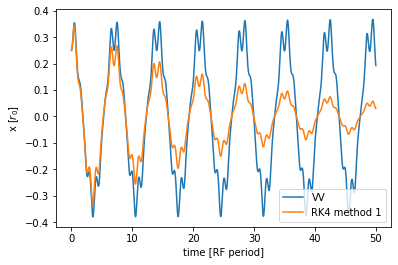

In [45]:
plt.figure('Ion algorithm',clear='True')
ax = plt.subplot(111)

ax.plot(t_vv/(100*dt_vv),np.array(x_vv)/r0,label='VV')
# ax.plot(t_vv/(100*dt),v_vv,color='g',ls='--',label='VV')
# ax.plot(t_vv/(100*dt),a1_vv,color='r',label='VV')

ax.plot(t_rk4/(nt*dt_rk4),np.array(x_rk4)/r0,label='RK4 method 1')
# ax.plot(t_rk4/(nt*dt_rk4),v_rk4,label='RK4')
# ax.plot(t_rk4/(nt*dt_rk4),a1_rk4,label='RK4')

ax.set_xlabel('time [RF period]')
ax.set_ylabel('x [$r_0$]')
ax.legend()

### 3.B With Runge-Kutta as in this [Stack exchange](https://math.stackexchange.com/questions/721076/help-with-using-the-runge-kutta-4th-order-method-on-a-system-of-2-first-order-od) (but I have seen this elsewhere)

Here the dynamic variables $y_i$ and $v_i$ are grouped into a single array $Y = [y_i, v_i]$. $a_i$ is known analytically because of Newton's second law with known forces.

In [104]:
# all in one
class runge_kutta_4:
    def derivs(x,v,t):
        return np.array([v, 2*C_e*Urf/(m_Ca*r0**2)*np.cos(Omega*t)*x - gamma/m_Ca*v])
    def update_slopes(Y,t,h):
        k1 = h*runge_kutta_4.derivs(Y[0],Y[1],t)
        k2 = h*runge_kutta_4.derivs(Y[0]+1/2*k1[0],Y[1]+1/2*k1[1],t+h/2)
        k3 = h*runge_kutta_4.derivs(Y[0]+1/2*k2[0],Y[1]+1/2*k2[1],t+h/2)
        k4 = h*runge_kutta_4.derivs(Y[0]+k3[0],Y[1]+k3[1],t+h)
        return k1, k2, k3, k4
    def update_pos_vel(Y,h,k1,k2,k3,k4):
        Y = Y + 1/6*(k1+2*k2+2*k3+k4)
        return Y

In [105]:
# variables simu
nt = 100
dt_rk4 = 2*np.pi/(nt*Omega) # s
h = dt_rk4
gamma = 1e-20 # Friction parameter
# with no friction VV and RK4 agree strongly

t_rk4 = np.arange(0,nper*nt*dt_rk4,dt_rk4)
x_rk4,v_rk4,a1_rk4 = [[],[],[]]

# initialisation
x_rk4.append(r0/4)
a1_rk4.append(velocity_verlet.update_acceleration(x_vv[0],t_vv[0]))
v_rk4.append(0)

# VV algorithm

for time in t_rk4[:-1]:
    Y = [x_rk4[-1],v_rk4[-1]]
    k1,k2,k3,k4 =  runge_kutta_4.update_slopes(Y,time,h)
    print(k1,k2,k3,k4)
    x_rk4 .append( runge_kutta_4.update_pos_vel(Y,h,k1,k2,k3,k4)[0] )
    v_rk4 .append( runge_kutta_4.update_pos_vel(Y,h,k1,k2,k3,k4)[1] )
    a1_rk4.append( runge_kutta_4.derivs(Y[0],Y[1],time)[1] )

[ 0.         96.28688136] [2.40717203e-07 9.62031993e+01] [2.40507998e-07 9.62217639e+01] [4.81108820e-07 9.60615689e+01]
[4.80998647e-07 9.60615985e+01] [7.21152644e-07 9.58249838e+01] [7.20561107e-07 9.58434895e+01] [9.60216095e-07 9.55302549e+01]
[9.60105981e-07 9.55303040e+01] [1.19893174e-06 9.51406078e+01] [1.19795750e-06 9.51589244e+01] [1.43590060e-06 9.46923879e+01]
[1.43579078e-06 9.46924559e+01] [1.67252192e-06 9.41493052e+01] [1.67116404e-06 9.41673054e+01] [1.90662730e-06 9.35469935e+01]
[1.90651800e-06 9.35470797e+01] [2.14038570e-06 9.28499051e+01] [2.13864277e-06 9.28674664e+01] [2.37085533e-06 9.20927286e+01]
[2.37074680e-06 9.20928322e+01] [2.60097888e-06 9.12409079e+01] [2.59884907e-06 9.12579142e+01] [2.82703637e-06 9.03279688e+01]
[2.82692883e-06 9.03280887e+01] [3.05274906e-06 8.93205844e+01] [3.05023029e-06 8.93369270e+01] [3.27361347e-06 8.82509180e+01]
[3.27350719e-06 8.82510529e+01] [3.49413482e-06 8.70870953e+01] [3.49122493e-06 8.71026751e+01] [3.70902057e-0

[-7.04170099e-06  2.40349408e+00] [-7.03569226e-06  2.50513804e+00] [-7.03543815e-06  2.50520083e+00] [-7.02917499e-06  2.57226167e+00]
[-7.02920397e-06  2.57226278e+00] [-7.02277331e-06  2.60495594e+00] [-7.02269158e-06  2.60508186e+00] [-7.01617856e-06  2.60374061e+00]
[-7.01620723e-06  2.60374363e+00] [-7.00969787e-06  2.56872079e+00] [-7.00978543e-06  2.56890380e+00] [-7.00336271e-06  2.50064780e+00]
[-7.00339087e-06  2.50065369e+00] [-6.99713923e-06  2.39965305e+00] [-6.99739173e-06  2.39988225e+00] [-6.99139145e-06  2.26668820e+00]
[-6.99141886e-06  2.26669785e+00] [-6.98575211e-06  2.10193220e+00] [-6.98616403e-06  2.10219227e+00] [-6.98090789e-06  1.90649696e+00]
[-6.98093432e-06  1.90651113e+00] [-6.97616804e-06  1.68063804e+00] [-6.97673272e-06  1.68090978e+00] [-6.97252977e-06  1.42558001e+00]
[-6.97255500e-06  1.42559936e+00] [-6.96899100e-06  1.14169096e+00] [-6.96970077e-06  1.14195192e+00] [-6.96684524e-06  8.30254334e-01]
[-6.96686905e-06  8.30279356e-01] [-6.96479335e-

[-9.68448703e-06 -1.72431502e+01] [-9.72759491e-06 -1.42652574e+01] [-9.72015017e-06 -1.42668955e+01] [-9.75582151e-06 -1.12284814e+01]
[-9.75576698e-06 -1.12285376e+01] [-9.78383832e-06 -8.13240759e+00] [-9.77609800e-06 -8.13377414e+00] [-9.79643585e-06 -4.98232312e+00]
[-9.79638633e-06 -4.98235553e+00] [-9.80884222e-06 -1.77859764e+00] [-9.80083283e-06 -1.77983128e+00] [-9.80528549e-06  1.47334638e+00]
[-9.80524122e-06  1.47333973e+00] [-9.80155787e-06  4.77272639e+00] [-9.79330940e-06  4.77147806e+00] [-9.78138383e-06  8.11368832e+00]
[-9.78134502e-06  8.11370910e+00] [-9.76106075e-06  1.14953505e+01] [-9.75260665e-06  1.14939331e+01] [-9.72387536e-06  1.49111233e+01]
[-9.72384219e-06  1.49111728e+01] [-9.68656426e-06  1.83603552e+01] [-9.67794130e-06  1.83586103e+01] [-9.63204914e-06  2.18354148e+01]
[-9.63202176e-06  2.18354937e+01] [-9.57743302e-06  2.53362200e+01] [-9.56868121e-06  2.53339876e+01] [-9.50535182e-06  2.88537953e+01]
[-9.50533034e-06  2.88539039e+01] [-9.43319558e-

[8.44400313e-06 3.79439840e+01] [8.53886309e-06 3.58494870e+01] [8.53362684e-06 3.58461667e+01] [8.62323396e-06 3.37463181e+01]
[8.62323780e-06 3.37461737e+01] [8.70760323e-06 3.16436639e+01] [8.70234696e-06 3.16411456e+01] [8.78144353e-06 2.95402622e+01]
[8.78145118e-06 2.95401312e+01] [8.85530151e-06 2.74435190e+01] [8.85005998e-06 2.74417240e+01] [8.91865980e-06 2.53534492e+01]
[8.91867123e-06 2.53533329e+01] [8.98205457e-06 2.32759745e+01] [8.97686117e-06 2.32748159e+01] [9.03504531e-06 2.12121839e+01]
[9.03506048e-06 2.12120835e+01] [9.08809069e-06 1.91666722e+01] [9.08297716e-06 1.91660569e+01] [9.13089077e-06 1.71413910e+01]
[9.13090959e-06 1.71413071e+01] [9.17376286e-06 1.51397777e+01] [9.16875904e-06 1.51396086e+01] [9.20660764e-06 1.31644316e+01]
[9.20663002e-06 1.31643643e+01] [9.23954093e-06 1.12178110e+01] [9.23467455e-06 1.12179892e+01] [9.26271997e-06 9.30294858e+00]
[9.26274578e-06 9.30289787e+00] [9.28600302e-06 7.42150605e+00] [9.28129955e-06 7.42193255e+00] [9.29985

[7.91497793e-06 4.04714016e+01] [8.01615644e-06 3.96379030e+01] [8.01407269e-06 3.96437271e+01] [8.11319657e-06 3.87480872e+01]
[8.11313022e-06 3.87481709e+01] [8.21000065e-06 3.77903137e+01] [8.20760601e-06 3.77956082e+01] [8.30210826e-06 3.67744883e+01]
[8.30204231e-06 3.67745770e+01] [8.39397875e-06 3.56902941e+01] [8.39126805e-06 3.56950420e+01] [8.48051752e-06 3.45466912e+01]
[8.48045226e-06 3.45467832e+01] [8.56681922e-06 3.33346493e+01] [8.56378888e-06 3.33388440e+01] [8.64714648e-06 3.20621929e+01]
[8.64708223e-06 3.20622863e+01] [8.72723794e-06 3.07215957e+01] [8.72388622e-06 3.07252423e+01] [8.80070844e-06 2.93199801e+01]
[8.80064551e-06 2.93200728e+01] [8.87394570e-06 2.78509164e+01] [8.87027281e-06 2.78540317e+01] [8.93991567e-06 2.63206818e+01]
[8.93985439e-06 2.63207715e+01] [9.00565632e-06 2.47241104e+01] [9.00166467e-06 2.47267232e+01] [9.06348801e-06 2.30667143e+01]
[9.06342868e-06 2.30667988e+01] [9.12109568e-06 2.13445329e+01] [9.11679002e-06 2.13466846e+01] [9.17016

[5.77427779e-06 2.99228918e+01] [5.84908502e-06 2.76043726e+01] [5.84328872e-06 2.76071955e+01] [5.91231376e-06 2.52364786e+01]
[5.91226321e-06 2.52365783e+01] [5.97535465e-06 2.28157031e+01] [5.96930247e-06 2.28179684e+01] [6.02635305e-06 2.03479539e+01]
[6.02630644e-06 2.03480382e+01] [6.07717653e-06 1.78310776e+01] [6.07088413e-06 1.78328779e+01] [6.11547083e-06 1.52703355e+01]
[6.11542834e-06 1.52704025e+01] [6.15360435e-06 1.26646217e+01] [6.14708990e-06 1.26660606e+01] [6.17875865e-06 1.00187691e+01]
[6.17872046e-06 1.00188168e+01] [6.20376750e-06 7.33250215e+00] [6.19705171e-06 7.33369284e+00] [6.21538892e-06 4.61045912e+00]
[6.21535518e-06 4.61048585e+00] [6.22688139e-06 1.85295702e+00] [6.21998757e-06 1.85402078e+00] [ 6.22462528e-06 -9.35314850e-01]
[ 6.22459612e-06 -9.35310468e-01] [ 6.22225784e-06 -3.75370268e+00] [ 6.21521186e-06 -3.75263829e+00] [ 6.20583292e-06 -6.59721234e+00]
[ 6.20580845e-06 -6.59723139e+00] [ 6.18931537e-06 -9.46512303e+00] [ 6.18214564e-06 -9.463926

[-1.57698838e-06 -1.73323272e+01] [-1.62031920e-06 -1.82591493e+01] [-1.62263625e-06 -1.82571021e+01] [-1.66827389e-06 -1.91566801e+01]
[-1.66825630e-06 -1.91567466e+01] [-1.71614817e-06 -2.00283222e+01] [-1.71832711e-06 -2.00259212e+01] [-1.76838591e-06 -2.08680137e+01]
[-1.76836734e-06 -2.08680824e+01] [-1.82053755e-06 -2.16800088e+01] [-1.82256736e-06 -2.16772407e+01] [-1.87675355e-06 -2.24575776e+01]
[-1.87673414e-06 -2.24576472e+01] [-1.93287826e-06 -2.32057920e+01] [-1.93474862e-06 -2.32026510e+01] [-1.99274740e-06 -2.39172587e+01]
[-1.99272730e-06 -2.39173277e+01] [-2.05252062e-06 -2.45978813e+01] [-2.05422200e-06 -2.45943689e+01] [-2.11569915e-06 -2.52396220e+01]
[-2.11567851e-06 -2.52396891e+01] [-2.17877773e-06 -2.58492151e+01] [-2.18030155e-06 -2.58453402e+01] [-2.24490521e-06 -2.64180113e+01]
[-2.24488419e-06 -2.64180752e+01] [-2.31092937e-06 -2.69535589e+01] [-2.31226808e-06 -2.69493379e+01] [-2.37963087e-06 -2.74466442e+01]
[-2.37960961e-06 -2.74467035e+01] [-2.44822637e-

[ 1.71273004e-06 -1.45474967e+01] [ 1.67636130e-06 -1.62463836e+01] [ 1.67211408e-06 -1.62465270e+01] [ 1.6314974e-06 -1.7922184e+01]
[ 1.63151712e-06 -1.79221196e+01] [ 1.58671182e-06 -1.95729682e+01] [ 1.58258470e-06 -1.95735171e+01] [ 1.53364953e-06 -2.11988419e+01]
[ 1.53367218e-06 -2.11987673e+01] [ 1.48067526e-06 -2.27970505e+01] [ 1.47667955e-06 -2.27980714e+01] [ 1.41968182e-06 -2.43687810e+01]
[ 1.41970735e-06 -2.43686976e+01] [ 1.35878561e-06 -2.59103776e+01] [ 1.35493141e-06 -2.59119290e+01] [ 1.29014771e-06 -2.74242156e+01]
[ 1.29017608e-06 -2.74241246e+01] [ 1.22161577e-06 -2.89056240e+01] [ 1.21791202e-06 -2.89077558e+01] [ 1.1456373e-06 -3.0358255e+01]
[ 1.14566846e-06 -3.03581579e+01] [ 1.06977307e-06 -3.17763245e+01] [ 1.06622765e-06 -3.17790778e+01] [ 9.86773073e-07 -3.31648312e+01]
[ 9.86806967e-07 -3.31647294e+01] [ 9.03895144e-07 -3.45167973e+01] [ 9.00514974e-07 -3.45202038e+01] [ 8.14205948e-07 -3.58386176e+01]
[ 8.14242510e-07 -3.58385127e+01] [ 7.24646228e-07 -

[-9.85492950e-07 -4.22354691e+01] [-1.09108162e-06 -4.10021941e+01] [-1.08799844e-06 -4.10084086e+01] [-1.19053499e-06 -3.97366531e+01]
[-1.19048739e-06 -3.97367692e+01] [-1.28982931e-06 -3.84276490e+01] [-1.28655651e-06 -3.84332013e+01] [-1.38265340e-06 -3.70865063e+01]
[-1.38260820e-06 -3.70866207e+01] [-1.47532476e-06 -3.57035289e+01] [-1.47186703e-06 -3.57084258e+01] [-1.56115033e-06 -3.42888149e+01]
[-1.56110766e-06 -3.42889260e+01] [-1.64682997e-06 -3.28340400e+01] [-1.64319276e-06 -3.28382981e+01] [-1.72529915e-06 -3.13481244e+01]
[-1.72525910e-06 -3.13482308e+01] [-1.80362967e-06 -2.98240824e+01] [-1.7998193e-06 -2.9827728e+01] [-1.87439774e-06 -2.82697239e+01]
[-1.87436041e-06 -2.82698240e+01] [-1.94503497e-06 -2.66793482e+01] [-1.94105878e-06 -2.66824172e+01] [-2.00777250e-06 -2.50597408e+01]
[-2.00773799e-06 -2.50598331e+01] [-2.07038757e-06 -2.34064127e+01] [-2.06625402e-06 -2.34089503e+01] [-2.12478274e-06 -2.17252283e+01]
[-2.12475115e-06 -2.17253113e+01] [-2.17906442e-06

[ 2.11811476e-06 -1.14179592e+01] [ 2.08956986e-06 -1.09418628e+01] [ 2.09076010e-06 -1.09409224e+01] [ 2.06341015e-06 -1.04447837e+01]
[ 2.06342450e-06 -1.04447565e+01] [ 2.03731261e-06 -9.92893527e+00] [ 2.03860216e-06 -9.92821589e+00] [ 2.01378342e-06 -9.39348051e+00]
[ 2.01379738e-06 -9.39345445e+00] [ 1.99031375e-06 -8.84021991e+00] [ 1.99169683e-06 -8.83970932e+00] [ 1.96959884e-06 -8.26877541e+00]
[ 1.96961231e-06 -8.26875132e+00] [ 1.94894043e-06 -7.68058579e+00] [ 1.95041085e-06 -7.68026735e+00] [ 1.93121097e-06 -7.07568977e+00]
[ 1.93122385e-06 -7.07566838e+00] [ 1.91353468e-06 -6.45519658e+00] [ 1.91508586e-06 -6.45504951e+00] [ 1.89894861e-06 -5.81951167e+00]
[ 1.89896079e-06 -5.81949370e+00] [ 1.88441206e-06 -5.16945497e+00] [ 1.88603716e-06 -5.16945469e+00] [ 1.87311352e-06 -4.50574138e+00]
[ 1.87312492e-06 -4.50572745e+00] [ 1.86186060e-06 -3.82894921e+00] [ 1.86355254e-06 -3.82906770e+00] [ 1.85397958e-06 -3.14003923e+00]
[ 1.85399008e-06 -3.14002992e+00] [ 1.84614001e-

[2.41917803e-06 5.08343333e+01] [2.54626386e-06 5.00662768e+01] [2.54434372e-06 5.00749915e+01] [2.66955299e-06 4.92593258e+01]
[2.66949153e-06 4.92594192e+01] [2.79264007e-06 4.83965558e+01] [2.79048292e-06 4.84047256e+01] [2.91151515e-06 4.74939777e+01]
[2.91145483e-06 4.74940772e+01] [3.03019002e-06 4.65359330e+01] [3.02779466e-06 4.65435198e+01] [3.14417243e-06 4.55373032e+01]
[3.14411340e-06 4.55374076e+01] [3.25795692e-06 4.44836906e+01] [3.25532262e-06 4.44906644e+01] [3.36656672e-06 4.33888044e+01]
[3.36650917e-06 4.33889123e+01] [3.47498145e-06 4.22395719e+01] [3.47210810e-06 4.22459119e+01] [3.57773873e-06 4.10485066e+01]
[3.57768282e-06 4.10486166e+01] [3.68030436e-06 3.98039060e+01] [3.67719259e-06 3.98096012e+01] [3.77673083e-06 3.85170844e+01]
[3.77667675e-06 3.85171948e+01] [3.87296974e-06 3.71777345e+01] [3.86962109e-06 3.71827839e+01] [3.96259067e-06 3.57959883e+01]
[3.96253860e-06 3.57960975e+01] [4.05202885e-06 3.43629383e+01] [4.04844595e-06 3.43673513e+01] [4.13437

[-3.06838509e-06 -2.36007938e+01] [-3.12738708e-06 -2.32971969e+01] [-3.12662808e-06 -2.32927862e+01] [-3.18484902e-06 -2.29628713e+01]
[-3.18483812e-06 -2.29628349e+01] [-3.24224521e-06 -2.26073180e+01] [-3.24135641e-06 -2.26030840e+01] [-3.29785354e-06 -2.22231379e+01]
[-3.29784377e-06 -2.22230951e+01] [-3.3534015e-06 -2.1819495e+01] [-3.35239250e-06 -2.18154701e+01] [-3.40692112e-06 -2.13895123e+01]
[-3.40691255e-06 -2.13894639e+01] [-3.46038621e-06 -2.09419766e+01] [-3.45926749e-06 -2.09381892e+01] [-3.51160349e-06 -2.04705766e+01]
[-3.51159619e-06 -2.04705235e+01] [-3.56277250e-06 -1.99836606e+01] [-3.56155534e-06 -1.99801344e+01] [-3.61149686e-06 -1.94755163e+01]
[-3.61149088e-06 -1.94754595e+01] [-3.66017953e-06 -1.89540010e+01] [-3.65887588e-06 -1.89507549e+01] [-3.70624466e-06 -1.84140240e+01]
[-3.70624004e-06 -1.84139645e+01] [-3.75227496e-06 -1.78629088e+01] [-3.75089732e-06 -1.78599563e+01] [-3.79553983e-06 -1.72961978e+01]
[-3.79553662e-06 -1.72961366e+01] [-3.83877696e-06

[-1.68065281e-06 -4.26000031e+01] [-1.78715282e-06 -4.28617838e+01] [-1.78780727e-06 -4.28698527e+01] [-1.89500207e-06 -4.30980382e+01]
[-1.89495390e-06 -4.30980129e+01] [-2.00269894e-06 -4.32920446e+01] [-2.00318401e-06 -4.33002671e+01] [-2.11145524e-06 -4.34598651e+01]
[-2.11140599e-06 -4.34598487e+01] [-2.22005561e-06 -4.35844819e+01] [-2.22036719e-06 -4.35928001e+01] [-2.32936999e-06 -4.36821057e+01]
[-2.32931975e-06 -4.36820984e+01] [-2.43852500e-06 -4.37355759e+01] [-2.43865869e-06 -4.37439305e+01] [-2.54803941e-06 -4.37611347e+01]
[-2.54798829e-06 -4.37611366e+01] [-2.65739113e-06 -4.37416013e+01] [-2.65734229e-06 -4.37499321e+01] [-2.76673795e-06 -4.36931323e+01]
[-2.76668607e-06 -4.36931437e+01] [-2.87591893e-06 -4.35986522e+01] [-2.87568270e-06 -4.36068992e+01] [-2.98472057e-06 -4.34741163e+01]
[-2.98466804e-06 -4.34741370e+01] [-3.09335338e-06 -4.33026794e+01] [-3.09292474e-06 -4.33107834e+01] [-3.20122196e-06 -4.30999835e+01]
[-3.20116891e-06 -4.31000134e+01] [-3.30891894e-

[-3.26260893e-07  4.20308022e+01] [-2.21183888e-07  4.29731605e+01] [-2.18827992e-07  4.29661121e+01] [-1.11430333e-07  4.38593526e+01]
[-1.11453643e-07  4.38594590e+01] [-1.80499580e-09  4.47026941e+01] [3.03092106e-10 4.46951074e+01] [1.12021894e-07 4.54863726e+01]
[1.11997552e-07 4.54864720e+01] [2.25713732e-07 4.62250056e+01] [2.27560066e-07 4.62169234e+01] [3.43082169e-07 4.69009834e+01]
[3.43056980e-07 4.69010739e+01] [4.60309665e-07 4.75300315e+01] [4.61882059e-07 4.75215061e+01] [5.80664511e-07 4.80938684e+01]
[5.80638661e-07 4.80939484e+01] [7.00873532e-07 4.86092258e+01] [7.02161726e-07 4.86003181e+01] [8.23640252e-07 4.90572902e+01]
[8.23613933e-07 4.90573581e+01] [9.46257329e-07 4.94556795e+01] [9.47253132e-07 4.94464578e+01] [1.07084622e-06 4.97852001e+01]
[1.07081963e-06 4.97852548e+01] [1.19528276e-06 5.00642206e+01] [1.19598018e-06 5.00547594e+01] [1.32109342e-06 5.02733285e+01]
[1.32106675e-06 5.02733689e+01] [1.44675017e-06 5.04314941e+01] [1.44714548e-06 5.04218726e+

[ 1.55896295e-06 -2.26842160e+00] [ 1.55329190e-06 -1.77208693e+00] [ 1.55453274e-06 -1.77223227e+00] [ 1.55010179e-06 -1.26705318e+00]
[ 1.55010953e-06 -1.26705034e+00] [ 1.54694190e-06 -7.53515101e-01] [ 1.54822574e-06 -7.53700347e-01] [ 1.54634102e-06 -2.32353862e-01]
[ 1.5463480e-06 -2.3235491e-01] [1.54576711e-06 2.96284189e-01] [1.54708871e-06 2.96084199e-01] [1.54782842e-06 8.31491074e-01]
[1.54783456e-06 8.31485889e-01] [1.54991327e-06 1.37311330e+00] [1.55126734e-06 1.37292491e+00] [1.55469918e-06 1.92027218e+00]
[1.55470442e-06 1.92026267e+00] [1.55950508e-06 2.47275565e+00] [1.56088631e-06 2.47260595e+00] [1.56706745e-06 3.02977129e+00]
[1.56707172e-06 3.02975735e+00] [1.57464611e-06 3.59099557e+00] [1.57604921e-06 3.59091201e+00] [1.58502628e-06 4.15577936e+00]
[1.58502951e-06 4.15576096e+00] [1.59541891e-06 4.72363409e+00] [1.59683860e-06 4.72364404e+00] [1.60864773e-06 5.29411011e+00]
[1.60864987e-06 5.29408726e+00] [1.62188508e-06 5.86650045e+00] [1.62331612e-06 5.866630

[1.12663092e-06 4.24316099e+01] [1.23270994e-06 4.21344149e+01] [1.23196696e-06 4.21423733e+01] [1.33734279e-06 4.18095856e+01]
[1.33729323e-06 4.18096303e+01] [1.44181731e-06 4.14413570e+01] [1.44089662e-06 4.14490708e+01] [1.54453858e-06 4.10448914e+01]
[1.54448938e-06 4.10449437e+01] [1.64710174e-06 4.06050063e+01] [1.64600189e-06 4.06124256e+01] [1.74755151e-06 4.01362596e+01]
[1.74750277e-06 4.01363189e+01] [1.84784356e-06 3.96241177e+01] [1.84656306e-06 3.96311969e+01] [1.94565875e-06 3.90824521e+01]
[1.94561060e-06 3.90825177e+01] [2.04331689e-06 3.84974726e+01] [2.04185428e-06 3.85041706e+01] [2.13813145e-06 3.78822931e+01]
[2.13808401e-06 3.78823643e+01] [2.23278993e-06 3.72239527e+01] [2.23114390e-06 3.72302337e+01] [2.32423518e-06 3.65347474e+01]
[2.32418859e-06 3.65348235e+01] [2.41552564e-06 3.58026210e+01] [2.41369514e-06 3.58084553e+01] [2.50323086e-06 3.50390047e+01]
[2.50318524e-06 3.50390845e+01] [2.59078295e-06 3.42328097e+01] [2.58876726e-06 3.42381740e+01] [2.67437

[-3.49865634e-06 -6.51539803e-01] [-3.50028519e-06 -3.32638619e-01] [-3.49948793e-06 -3.32746607e-01] [-3.50032007e-06 -2.99768193e-02]
[-3.50033324e-06 -2.99722684e-02] [-3.50040817e-06  2.56337930e-01] [-3.49969240e-06  2.56230559e-01] [-3.49905209e-06  5.25769060e-01]
[-3.4990658e-06  5.2577112e-01] [-3.49775137e-06  7.78275022e-01] [-3.49712011e-06  7.78183349e-01] [-3.49517488e-06  1.01343471e+00]
[-3.49518903e-06  1.01343480e+00] [-3.49265544e-06  1.23123781e+00] [-3.49211094e-06  1.23117436e+00] [-3.48903316e-06  1.43140097e+00]
[-3.48904765e-06  1.43139964e+00] [-3.48546915e-06  1.61392241e+00] [-3.48501284e-06  1.61389697e+00] [-3.48097816e-06  1.77867264e+00]
[-3.48099289e-06  1.77867046e+00] [-3.47654621e-06  1.92564076e+00] [-3.47617879e-06  1.92566027e+00] [-3.47136459e-06  2.05486099e+00]
[-3.47137944e-06  2.05485853e+00] [-3.46624230e-06  2.16630086e+00] [-3.46596369e-06  2.16636940e+00] [-3.46054760e-06  2.26016198e+00]
[-3.46056248e-06  2.26015980e+00] [-3.45491208e-06

[-3.84502879e-06 -2.44441014e+01] [-3.90613905e-06 -2.36540464e+01] [-3.90416391e-06 -2.36572283e+01] [-3.96331493e-06 -2.28313125e+01]
[-3.9632771e-06 -2.2831378e+01] [-4.02035554e-06 -2.19700197e+01] [-4.01820215e-06 -2.19728146e+01] [-4.07314117e-06 -2.10757001e+01]
[-4.07310438e-06 -2.10757651e+01] [-4.1257938e-06 -2.0143411e+01] [-4.12346291e-06 -2.01458272e+01] [-4.17383352e-06 -1.91780368e+01]
[-4.17379795e-06 -1.91780999e+01] [-4.22174320e-06 -1.81754911e+01] [-4.21923668e-06 -1.81775444e+01] [-4.26468567e-06 -1.71400554e+01]
[-4.26465147e-06 -1.71401155e+01] [-4.30750176e-06 -1.60684686e+01] [-4.30482264e-06 -1.60701820e+01] [-4.34500238e-06 -1.49644675e+01]
[-4.34496971e-06 -1.49645231e+01] [-4.38238102e-06 -1.38255690e+01] [-4.37953363e-06 -1.38269730e+01] [-4.41410457e-06 -1.26550381e+01]
[-4.41407358e-06 -1.26550880e+01] [-4.44571130e-06 -1.14511068e+01] [-4.44270135e-06 -1.14522390e+01] [-4.47133477e-06 -1.02166539e+01]
[-4.47130561e-06 -1.02166968e+01] [-4.49684735e-06 -

[3.47286556e-06 2.68070299e+01] [3.53988313e-06 2.58726630e+01] [3.53754721e-06 2.58691417e+01] [3.60221127e-06 2.49167924e+01]
[3.60220508e-06 2.49167062e+01] [3.66449685e-06 2.39476536e+01] [3.66207422e-06 2.39446248e+01] [3.72192821e-06 2.29611666e+01]
[3.72192378e-06 2.29610824e+01] [3.77932648e-06 2.19645211e+01] [3.77683508e-06 2.19619714e+01] [3.83173363e-06 2.09545915e+01]
[3.83173099e-06 2.09545105e+01] [3.88411727e-06 1.99376271e+01] [3.88157506e-06 1.99355358e+01] [3.93140867e-06 1.89113948e+01]
[3.93140785e-06 1.89113183e+01] [3.97868615e-06 1.78812368e+01] [3.97611094e-06 1.78795768e+01] [4.02080573e-06 1.68457385e+01]
[4.02080675e-06 1.68456676e+01] [4.06292092e-06 1.58093811e+01] [4.06033021e-06 1.58081190e+01] [4.09984735e-06 1.47714839e+01]
[4.09985021e-06 1.47714195e+01] [4.13677876e-06 1.37357258e+01] [4.13418953e-06 1.37348234e+01] [4.16852433e-06 1.27020666e+01]
[4.16852903e-06 1.27020094e+01] [4.20028406e-06 1.16734512e+01] [4.19771266e-06 1.16728662e+01] [4.22689

[2.87119948e-06 1.89819326e+01] [2.91865431e-06 1.90210410e+01] [2.91875208e-06 1.90245366e+01] [2.96632216e-06 1.90440042e+01]
[2.96629705e-06 1.90440036e+01] [3.01390706e-06 1.90433052e+01] [3.01390532e-06 1.90467560e+01] [3.06153083e-06 1.90253215e+01]
[3.06150493e-06 1.90253258e+01] [3.10906824e-06 1.89826671e+01] [3.10896159e-06 1.89860456e+01] [3.15643515e-06 1.89215749e+01]
[3.15640853e-06 1.89215842e+01] [3.20371249e-06 1.88348558e+01] [3.20349567e-06 1.88381351e+01] [3.25059921e-06 1.87285499e+01]
[3.25057196e-06 1.87285641e+01] [3.29739337e-06 1.85957243e+01] [3.29706127e-06 1.85988786e+01] [3.34356635e-06 1.84421812e+01]
[3.34353859e-06 1.84422001e+01] [3.38964409e-06 1.82613005e+01] [3.38919184e-06 1.82643058e+01] [3.43486012e-06 1.80586058e+01]
[3.43483194e-06 1.80586292e+01] [3.47997851e-06 1.78278428e+01] [3.47940154e-06 1.78306774e+01] [3.52398532e-06 1.75742209e+01]
[3.52395684e-06 1.75742483e+01] [3.56789246e-06 1.72918995e+01] [3.56718659e-06 1.72945442e+01] [3.61042

[-4.71669501e-07 -4.75505641e+01] [-5.90545912e-07 -4.75669982e+01] [-5.90586997e-07 -4.75578395e+01] [-7.09458699e-07 -4.75180043e+01]
[-7.09434704e-07 -4.75180112e+01] [-8.28229733e-07 -4.74220407e+01] [-8.27989806e-07 -4.74129306e+01] [-9.46499357e-07 -4.72611059e+01]
[-9.46475588e-07 -4.72610984e+01] [-1.06462833e-06 -4.70536927e+01] [-1.06410982e-06 -4.70447098e+01] [-1.18169914e-06 -4.67823067e+01]
[-1.18167576e-06 -4.67822850e+01] [-1.29863147e-06 -4.64652946e+01] [-1.29783900e-06 -4.64565156e+01] [-1.41395834e-06 -4.60858164e+01]
[-1.41393553e-06 -4.60857809e+01] [-1.52914998e-06 -4.56619162e+01] [-1.52809032e-06 -4.56534142e+01] [-1.64220260e-06 -4.51775452e+01]
[-1.64218052e-06 -4.51774969e+01] [-1.75512426e-06 -4.46502955e+01] [-1.75380626e-06 -4.46421390e+01] [-1.86539121e-06 -4.40650334e+01]
[-1.86537002e-06 -4.40649733e+01] [-1.97553245e-06 -4.34387581e+01] [-1.97396691e-06 -4.34310092e+01] [-2.08252507e-06 -4.27573597e+01]
[-2.08250491e-06 -4.27572889e+01] [-2.18939813e-

[-2.76154716e-06 -7.01703009e-02] [-2.76172258e-06  1.78978804e-01] [-2.76109971e-06  1.78885635e-01] [-2.76065273e-06  4.14816857e-01]
[-2.76066351e-06  4.14818477e-01] [-2.75962647e-06  6.37301326e-01] [-2.75907026e-06  6.37220260e-01] [-2.75747741e-06  8.46060216e-01]
[-2.75748858e-06  8.46060099e-01] [-2.75537343e-06  1.04107964e+00] [-2.75488588e-06  1.04102172e+00] [-2.75228347e-06  1.22209957e+00]
[-2.75229494e-06  1.22209815e+00] [-2.74923970e-06  1.38911086e+00] [-2.74882216e-06  1.38908494e+00] [-2.74534952e-06  1.54198047e+00]
[-2.74536122e-06  1.54197821e+00] [-2.74150627e-06  1.68068788e+00] [-2.74115950e-06  1.68070055e+00] [-2.73695771e-06  1.80523705e+00]
[-2.73696956e-06  1.80523440e+00] [-2.73245647e-06  1.91558408e+00] [-2.73218060e-06  1.91563961e+00] [-2.72739136e-06  2.01187492e+00]
[-2.72740326e-06  2.01187234e+00] [-2.72237358e-06  2.09403456e+00] [-2.72216817e-06  2.09413494e+00] [-2.71693258e-06  2.16235108e+00]
[-2.71694446e-06  2.16234899e+00] [-2.71153858e-

[-1.97838785e-06 -2.48205142e+01] [-2.04043914e-06 -2.46858295e+01] [-2.04010243e-06 -2.46903773e+01] [-2.10183974e-06 -2.45321752e+01]
[-2.10180877e-06 -2.45321965e+01] [-2.16313926e-06 -2.43502858e+01] [-2.16268449e-06 -2.43546898e+01] [-2.22358222e-06 -2.41486034e+01]
[-2.22355106e-06 -2.41486297e+01] [-2.28392264e-06 -2.39182142e+01] [-2.28334660e-06 -2.39224443e+01] [-2.34316329e-06 -2.36672131e+01]
[-2.34313203e-06 -2.36672442e+01] [-2.40230014e-06 -2.33870864e+01] [-2.40159975e-06 -2.33911146e+01] [-2.46008760e-06 -2.30855329e+01]
[-2.46005635e-06 -2.30855684e+01] [-2.51777027e-06 -2.27544984e+01] [-2.51694259e-06 -2.27582997e+01] [-2.57384785e-06 -2.24012438e+01]
[-2.57381669e-06 -2.24012832e+01] [-2.62981990e-06 -2.20182284e+01] [-2.62886226e-06 -2.20217809e+01] [-2.68392559e-06 -2.16122397e+01]
[-2.68389464e-06 -2.16122826e+01] [-2.73792535e-06 -2.11762981e+01] [-2.73683538e-06 -2.11795838e+01] [-2.78979256e-06 -2.07166908e+01]
[-2.78976192e-06 -2.07167365e+01] [-2.84155376e-

[-4.3391369e-07  2.4655212e+01] [-3.72275660e-07  2.52992042e+01] [-3.70665679e-07  2.52952107e+01] [-3.07437637e-07  2.59112074e+01]
[-3.07450982e-07  2.59112767e+01] [-2.42672790e-07  2.64986414e+01] [-2.41204379e-07  2.64942937e+01] [-1.74979514e-07  2.70516721e+01]
[-1.74993633e-07  2.70517384e+01] [-1.07364287e-07  2.75785653e+01] [-1.06047220e-07  2.75738834e+01] [-3.71242163e-08  2.80689221e+01]
[-3.71390016e-08  2.80689842e+01] [3.30334588e-08 2.85317462e+01] [3.41903638e-08 2.85267561e+01] [1.05494779e-07 2.89561405e+01]
[1.05479439e-07 2.89561971e+01] [1.77869932e-07 2.93517965e+01] [1.78858931e-07 2.93465303e+01] [2.52212091e-07 2.97073958e+01]
[2.52196312e-07 2.97074461e+01] [3.26464927e-07 3.00332558e+01] [3.27279451e-07 3.00277507e+01] [4.02335065e-07 3.03177227e+01]
[4.02318963e-07 3.03177656e+01] [4.78113377e-07 3.05716663e+01] [4.78748129e-07 3.05659643e+01] [5.55148785e-07 3.07831912e+01]
[5.55132478e-07 3.07832259e+01] [6.32090543e-07 3.09636364e+01] [6.32541569e-07 

[2.77617076e-06 1.26841719e+01] [2.80788119e-06 1.24377098e+01] [2.80726503e-06 1.24395296e+01] [2.83836841e-06 1.21725204e+01]
[2.83834673e-06 1.21725455e+01] [2.86877810e-06 1.18849169e+01] [2.86805903e-06 1.18865751e+01] [2.89777961e-06 1.15779638e+01]
[2.89775798e-06 1.15779907e+01] [2.92670295e-06 1.12483841e+01] [2.92587894e-06 1.12498744e+01] [2.95400735e-06 1.08989557e+01]
[2.95398586e-06 1.08989839e+01] [2.98123332e-06 1.05268036e+01] [2.98030287e-06 1.05281232e+01] [3.00662648e-06 1.01344208e+01]
[3.00660525e-06 1.01344497e+01] [3.03194137e-06 9.71934192e+00] [3.03090360e-06 9.72049132e+00] [3.0552077e-06 9.2837839e+00]
[3.05518683e-06 9.28381278e+00] [3.07839636e-06 8.82569053e+00] [3.07725106e-06 8.82667428e+00] [3.09932020e-06 8.34701967e+00]
[3.09929980e-06 8.34704784e+00] [3.12016742e-06 7.84611563e+00] [3.11891509e-06 7.84694219e+00] [3.13853451e-06 7.32470140e+00]
[3.13851469e-06 7.32472809e+00] [3.15682651e-06 6.78150469e+00] [3.15546845e-06 6.78218656e+00] [3.1724256

[-2.04841388e-06 -2.93074743e+01] [-2.12168257e-06 -2.85610009e+01] [-2.11981638e-06 -2.85566134e+01] [-2.19119695e-06 -2.77832630e+01]
[-2.19118552e-06 -2.77831876e+01] [-2.26064349e-06 -2.69839510e+01] [-2.25864540e-06 -2.69800236e+01] [-2.32608564e-06 -2.61568438e+01]
[-2.32607550e-06 -2.61567666e+01] [-2.39146742e-06 -2.53106872e+01] [-2.38935222e-06 -2.53072266e+01] [-2.45261164e-06 -2.44402503e+01]
[-2.45260287e-06 -2.44401728e+01] [-2.51370331e-06 -2.35533876e+01] [-2.51148634e-06 -2.35503927e+01] [-2.57035484e-06 -2.26458362e+01]
[-2.57034752e-06 -2.26457597e+01] [-2.62696191e-06 -2.17245549e+01] [-2.62465890e-06 -2.17220169e+01] [-2.67895760e-06 -2.07862116e+01]
[-2.67895178e-06 -2.07861373e+01] [-2.73091712e-06 -1.98368805e+01] [-2.72854398e-06 -1.98347837e+01] [-2.77812570e-06 -1.88741094e+01]
[-2.77812142e-06 -1.88740386e+01] [-2.82530652e-06 -1.79031126e+01] [-2.82287920e-06 -1.79014343e+01] [-2.86762859e-06 -1.69222544e+01]
[-2.86762591e-06 -1.69221881e+01] [-2.90993138e-

[-2.09983555e-06 -2.84410122e+00] [-2.10694580e-06 -2.96141351e+00] [-2.10723908e-06 -2.96188476e+00] [-2.11464497e-06 -3.07302077e+00]
[-2.11463865e-06 -3.07300777e+00] [-2.12232117e-06 -3.17750414e+00] [-2.12258241e-06 -3.17800800e+00] [-2.13052869e-06 -3.27551443e+00]
[-2.13052160e-06 -3.27550341e+00] [-2.13871036e-06 -3.36557820e+00] [-2.13893555e-06 -3.36610638e+00] [-2.14735214e-06 -3.44840168e+00]
[-2.14734433e-06 -3.44839278e+00] [-2.15596531e-06 -3.52249162e+00] [-2.15615056e-06 -3.52303538e+00] [-2.16495951e-06 -3.58859431e+00]
[-2.16495103e-06 -3.58858761e+00] [-2.17392250e-06 -3.64521739e+00] [-2.17406408e-06 -3.64576769e+00] [-2.18317987e-06 -3.69313164e+00]
[-2.18317077e-06 -3.69312719e+00] [-2.19240359e-06 -3.73086672e+00] [-2.19249794e-06 -3.73141450e+00] [-2.20182785e-06 -3.75920252e+00]
[-2.20181818e-06 -3.75920030e+00] [-2.21121619e-06 -3.77671168e+00] [-2.21125996e-06 -3.77724813e+00] [-2.22070442e-06 -3.78416863e+00]
[-2.22069426e-06 -3.78416857e+00] [-2.23015468e-

[-2.35420548e-06  1.68311156e+01] [-2.31212769e-06  1.77341472e+01] [-2.30987011e-06  1.77319861e+01] [-2.26554554e-06  1.86247509e+01]
[-2.26554870e-06  1.86248197e+01] [-2.21898665e-06  1.95062549e+01] [-2.21678306e-06  1.95037255e+01] [-2.16803007e-06  2.03719824e+01]
[-2.16803473e-06  2.03720555e+01] [-2.11710459e-06  2.12260910e+01] [-2.11496950e-06  2.12231758e+01] [-2.06191885e-06  2.20611268e+01]
[-2.06192497e-06  2.20612031e+01] [-2.00677196e-06  2.28820550e+01] [-2.00471983e-06  2.28787426e+01] [-1.94753125e-06  2.36806396e+01]
[-1.94753877e-06  2.36807178e+01] [-1.88833697e-06  2.44626820e+01] [-1.88638206e-06  2.44589676e+01] [-1.82524393e-06  2.52191727e+01]
[-1.82525278e-06  2.52192518e+01] [-1.76220465e-06  2.59567653e+01] [-1.76036086e-06  2.59526508e+01] [-1.69548952e-06  2.66656985e+01]
[-1.69549962e-06  2.66657771e+01] [-1.62883518e-06  2.73534798e+01] [-1.62711592e-06  2.73489743e+01] [-1.55875475e-06  2.80096327e+01]
[-1.55876603e-06  2.80097095e+01] [-1.48874175e-

[2.62333357e-06 1.80877833e+00] [2.62785552e-06 1.24024674e+00] [2.62643419e-06 1.24042753e+00] [2.62953571e-06 6.83136767e-01]
[2.62954462e-06 6.83130843e-01] [2.63125245e-06 1.37654382e-01] [2.62988876e-06 1.37855159e-01] [ 2.63023390e-06 -3.95220068e-01]
[ 2.63024373e-06 -3.95221545e-01] [ 2.62925568e-06 -9.15370363e-01] [ 2.62795531e-06 -9.15177360e-01] [ 2.62566785e-06 -1.42191544e+00]
[ 2.62567854e-06 -1.42191286e+00] [ 2.62212376e-06 -1.91476601e+00] [ 2.62089162e-06 -1.91460663e+00] [ 2.61610551e-06 -2.39319105e+00]
[ 2.61611700e-06 -2.39318485e+00] [ 2.61013404e-06 -2.85707943e+00] [ 2.60897430e-06 -2.85697727e+00] [ 2.60183211e-06 -3.30589541e+00]
[ 2.60184434e-06 -3.30588608e+00] [ 2.59357962e-06 -3.73946137e+00] [ 2.59249568e-06 -3.73943737e+00] [ 2.58314715e-06 -4.15747592e+00]
[ 2.58316004e-06 -4.15746401e+00] [ 2.57276638e-06 -4.55965513e+00] [ 2.57176090e-06 -4.55972741e+00] [ 2.56036140e-06 -4.94596452e+00]
[ 2.56037488e-06 -4.94595060e+00] [ 2.54801000e-06 -5.31597928

[2.22425293e-06 8.64473555e+00] [2.24586476e-06 8.40114622e+00] [2.24525579e-06 8.40225806e+00] [2.26626422e-06 8.14251223e+00]
[2.26624797e-06 8.14253314e+00] [2.2866043e-06 7.8666604e+00] [2.28591462e-06 7.86764540e+00] [2.30558620e-06 7.57544484e+00]
[2.30557013e-06 7.57546630e+00] [2.32450880e-06 7.26701777e+00] [2.32373767e-06 7.26787624e+00] [2.34190951e-06 6.94302911e+00]
[2.34189370e-06 6.94305062e+00] [2.35925133e-06 6.60193676e+00] [2.35839854e-06 6.60267191e+00] [2.37490706e-06 6.24519861e+00]
[2.37489159e-06 6.24521962e+00] [2.39050464e-06 5.87157219e+00] [2.38957052e-06 5.87219019e+00] [2.40425254e-06 5.48234131e+00]
[2.40423749e-06 5.48236126e+00] [2.41794340e-06 5.07655062e+00] [2.41692887e-06 5.07706069e+00] [2.42962280e-06 4.65533362e+00]
[2.42960826e-06 4.65535193e+00] [2.44124664e-06 4.21800297e+00] [2.44015327e-06 4.21841738e+00] [2.45070034e-06 3.76557132e+00]
[2.45068639e-06 3.76558739e+00] [2.46010036e-06 3.29759359e+00] [2.45893038e-06 3.29792758e+00] [2.4671760

[-2.28534226e-07 -2.85156628e+01] [-2.99823383e-07 -2.85296884e+01] [-2.99858447e-07 -2.85241945e+01] [-3.71155199e-07 -2.85044849e+01]
[-3.71140821e-07 -2.85044896e+01] [-4.42402045e-07 -2.84511144e+01] [-4.42268607e-07 -2.84456479e+01] [-5.13369060e-07 -2.83587601e+01]
[-5.13354799e-07 -2.83587562e+01] [-5.84251690e-07 -2.82385088e+01] [-5.83951072e-07 -2.82331171e+01] [-6.54520385e-07 -2.80798449e+01]
[-6.54506344e-07 -2.80798323e+01] [-7.24705924e-07 -2.78937704e+01] [-7.24240770e-07 -2.78884994e+01] [-7.93948841e-07 -2.76701595e+01]
[-7.93935120e-07 -2.76701388e+01] [-8.63110467e-07 -2.74198363e+01] [-8.62484711e-07 -2.74147301e+01] [-9.31008771e-07 -2.71331469e+01]
[-9.30995469e-07 -2.71331184e+01] [-9.98828265e-07 -2.68206472e+01] [-9.98047087e-07 -2.68157469e+01] [-1.06507420e-06 -2.64732301e+01]
[-1.06506142e-06 -2.64731945e+01] [-1.13124440e-06 -2.61010989e+01] [-1.13031416e-06 -2.60964420e+01] [-1.19554363e-06 -2.56957590e+01]
[-1.19553145e-06 -2.56957170e+01] [-1.25977074e-

[-1.16153013e-06 -1.02371696e+01] [-1.18712305e-06 -1.00784831e+01] [-1.18672634e-06 -1.00766187e+01] [-1.21191322e-06 -9.90726121e+00]
[-1.21190899e-06 -9.90724235e+00] [-1.23667710e-06 -9.72752647e+00] [-1.23622781e-06 -9.72576186e+00] [-1.26053780e-06 -9.53623665e+00]
[-1.26053404e-06 -9.53621549e+00] [-1.28437458e-06 -9.33721679e+00] [-1.28387708e-06 -9.33556368e+00] [-1.30721186e-06 -9.12768626e+00]
[-1.30720859e-06 -9.12766319e+00] [-1.33002775e-06 -8.91126341e+00] [-1.32948675e-06 -8.90973152e+00] [-1.35175725e-06 -8.68544255e+00]
[-1.3517545e-06 -8.6854180e+00] [-1.37346805e-06 -8.45361386e+00] [-1.37288854e-06 -8.45221065e+00] [-1.39401556e-06 -8.21355508e+00]
[-1.39401336e-06 -8.21352949e+00] [-1.41454718e-06 -7.96841117e+00] [-1.41393438e-06 -7.96714180e+00] [-1.43384907e-06 -7.71624697e+00]
[-1.43384742e-06 -7.71622078e+00] [-1.45313798e-06 -7.45994958e+00] [-1.45249730e-06 -7.45881686e+00] [-1.47114151e-06 -7.19786981e+00]
[-1.47114044e-06 -7.19784347e+00] [-1.48913505e-06

[-6.64380354e-07  1.33210056e+01] [-6.31077840e-07  1.32802018e+01] [-6.31179850e-07  1.32777136e+01] [-5.97991786e-07  1.32207627e+01]
[-5.97999021e-07  1.32207590e+01] [-5.64947124e-07  1.31476483e+01] [-5.65129901e-07  1.31452309e+01] [-5.32272867e-07  1.30560796e+01]
[-5.32280191e-07  1.30560721e+01] [-4.99640011e-07  1.29509083e+01] [-4.99902920e-07  1.29485822e+01] [-4.67537280e-07  1.28276082e+01]
[-4.6754464e-07  1.2827597e+01] [-4.35475647e-07  1.26908806e+01] [-4.35817438e-07  1.26886648e+01] [-4.04101315e-07  1.25364875e+01]
[-4.0410866e-07  1.2536473e+01] [-3.72767478e-07  1.23689418e+01] [-3.73186306e-07  1.23668537e+01] [-3.42274392e-07  1.21843242e+01]
[-3.42281670e-07  1.21843067e+01] [-3.11820903e-07  1.19869239e+01] [-3.12314360e-07  1.19849785e+01] [-2.82356778e-07  1.17731663e+01]
[-2.82363939e-07  1.17731462e+01] [-2.52931073e-07  1.15470858e+01] [-2.53496224e-07  1.15452956e+01] [-2.24637461e-07  1.13054726e+01]
[-2.24644454e-07  1.13054504e+01] [-1.96380828e-07  

[ 7.57762827e-07 -1.64566464e+01] [ 7.16621211e-07 -1.65172390e+01] [ 7.16469729e-07 -1.65203090e+01] [ 6.75161282e-07 -1.65670385e+01]
[ 6.75180509e-07 -1.65670342e+01] [ 6.33762924e-07 -1.65999780e+01] [ 6.33680564e-07 -1.66031167e+01] [ 5.92164926e-07 -1.66224384e+01]
[ 5.92184124e-07 -1.66224375e+01] [ 5.50628031e-07 -1.66282282e+01] [ 5.50613554e-07 -1.66314129e+01] [ 5.09027060e-07 -1.66238058e+01]
[ 5.09046187e-07 -1.66238083e+01] [ 4.67486666e-07 -1.66029070e+01] [ 4.67538919e-07 -1.66061146e+01] [ 4.26015614e-07 -1.65720204e+01]
[ 4.26034627e-07 -1.65720264e+01] [ 3.84604561e-07 -1.65248543e+01] [ 3.84722491e-07 -1.65280618e+01] [ 3.43394318e-07 -1.64678810e+01]
[ 3.43413177e-07 -1.64678903e+01] [ 3.02243451e-07 -1.63948263e+01] [ 3.02426111e-07 -1.63980110e+01] [ 2.61423122e-07 -1.63121009e+01]
[ 2.61441789e-07 -1.63121134e+01] [ 2.20661505e-07 -1.62134931e+01] [ 2.20908056e-07 -1.62166328e+01] [ 1.80358625e-07 -1.61053083e+01]
[ 1.80377061e-07 -1.61053239e+01] [ 1.40113751e-

[9.26636022e-07 5.90242692e-02] [ 9.26783583e-07 -1.27066411e-03] [ 9.26632845e-07 -1.25814191e-03] [ 9.26629731e-07 -6.36917782e-02]
[ 9.26627918e-07 -6.36985112e-02] [ 9.26468672e-07 -1.28102565e-01] [ 9.26307661e-07 -1.28067114e-01] [ 9.25987582e-07 -1.94204181e-01]
[ 9.25986049e-07 -1.94211643e-01] [ 9.25500520e-07 -2.61907793e-01] [ 9.25331280e-07 -2.61847173e-01] [ 9.24676814e-07 -3.30853829e-01]
[ 9.24675570e-07 -3.30861915e-01] [ 9.23848415e-07 -4.01000782e-01] [ 9.23673068e-07 -4.00913249e-01] [ 9.22671004e-07 -4.71927059e-01]
[ 9.22670056e-07 -4.71935649e-01] [ 9.21490217e-07 -5.43643053e-01] [ 9.21310948e-07 -5.43527423e-01] [ 9.19952419e-07 -6.15665121e-01]
[ 9.19951771e-07 -6.15674081e-01] [ 9.18412586e-07 -6.88058991e-01] [ 9.18231624e-07 -6.87914697e-01] [ 9.16512197e-07 -7.60280278e-01]
[ 9.16511853e-07 -7.60289464e-01] [ 9.14611129e-07 -8.32452231e-01] [ 9.14430722e-07 -8.32279361e-01] [ 9.12350456e-07 -9.03972404e-01]
[ 9.12350415e-07 -9.03981666e-01] [ 9.10090461e-07

[-9.48484061e-07  5.20690639e+00] [-9.35466795e-07  5.66728913e+00] [-9.34315838e-07  5.66745584e+00] [-9.20146781e-07  6.11835669e+00]
[-9.20155100e-07  6.11833619e+00] [-9.04859259e-07  6.55936379e+00] [-9.03756690e-07  6.55966605e+00] [-8.87356770e-07  6.99070985e+00]
[-8.87365845e-07  6.99068712e+00] [-8.69889127e-07  7.41138244e+00] [-8.68837389e-07  7.41183557e+00] [-8.50306667e-07  7.82212531e+00]
[-8.50316471e-07  7.82210079e+00] [-8.30761219e-07  8.22164682e+00] [-8.29762354e-07  8.22226351e+00] [-8.09205154e-07  8.61105658e+00]
[-8.09215656e-07  8.61103071e+00] [-7.87688079e-07  8.98875875e+00] [-7.86743759e-07  8.98954894e+00] [-7.64267912e-07  9.35624455e+00]
[-7.64279081e-07  9.35621779e+00] [-7.40888536e-07  9.71159427e+00] [-7.40000095e-07  9.71256508e+00] [-7.15716255e-07  1.00566906e+01]
[-7.15728058e-07  1.00566634e+01] [-6.90586400e-07  1.03892756e+01] [-6.89754869e-07  1.03904314e+01] [-6.63775901e-07  1.07116277e+01]
[-6.63788304e-07  1.07116004e+01] [-6.37009303e-

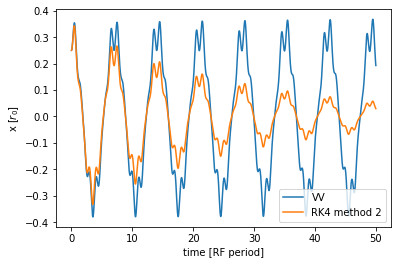

In [44]:
plt.figure('Ion algorithm',clear='True')
ax = plt.subplot(111)

ax.plot(t_vv/(100*dt_vv),np.array(x_vv)/r0,label='VV')
# ax.plot(t_vv/(100*dt),v_vv,color='g',ls='--',label='VV')
# ax.plot(t_vv/(100*dt),a1_vv,color='r',label='VV')

ax.plot(t_rk4/(nt*dt_rk4),np.array(x_rk4)/r0,label='RK4 method 2')
# ax.plot(t_rk4/(nt*dt_rk4),v_rk4,label='RK4')
# ax.plot(t_rk4/(nt*dt_rk4),a1_rk4,label='RK4')

ax.set_xlabel('time [RF period]')
ax.set_ylabel('x [$r_0$]')
ax.legend()

## Other references
https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Python.html

http://spiff.rit.edu/richmond/nbody/OrbitRungeKutta4.pdf

https://physics.stackexchange.com/search?q=runge+kutta+4

# Loading data from Fortran version
```gfortran -o3 .\Runge_Kutta_ions.f90 -o a.exe; .\a.exe```

In [159]:
with open('K:\\Universite_Simus\\20220215\\xva.dat') as f:
    t_For,r_For,v_For,a_For = np.loadtxt(f,unpack=True)

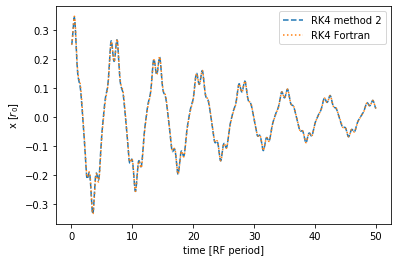

In [163]:
plt.figure('Pendulum algorithm',clear='True')
ax = plt.subplot(111)

# ax.plot(t_vv/(100*dt_vv),np.array(x_vv)/r0,label='VV')
# ax.plot(t_vv/(100*dt_vv),v_vv,color='g',label='VV')
# ax.plot(t_vv/(100*dt_vv),a1_vv,color='r',label='VV')

ax.plot(t_rk4/(nt*dt_rk4),np.array(x_rk4)/r0,ls='--',label='RK4 method 2')
# ax.plot(t_rk4/(nt*dt_rk4),v_rk4,ls='--',label='RK4')
# ax.plot(t_rk4/(nt*dt_rk4),a1_rk4,ls='--',label='RK4')

ax.plot(t_For/(nt*dt_rk4),np.array(r_For)/r0,ls=':',label='RK4 Fortran')
# ax.plot(t_For/(nt*dt_rk4),v_For,ls=':',label='RK4 Fortran')
# ax.plot(t_For/(nt*dt_rk4),a_For,ls=':',label='RK4 Fortran')

ax.set_xlabel('time [RF period]')
ax.set_ylabel('x [$r_0$]')
ax.legend()